In [2]:
import copy
import japanize_matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy 
from matplotlib.pyplot import imshow
from numpy.random import randn
from scipy import stats

In [3]:
def liner(X, y):
    """linear regression

    Args:
        X (_type_): 説明変数
        y (_type_): target 
    """
    p = X.shape[1]
    x_bar = [np.mean(X[:, j]) for j in range(p)]
    X = [X[:, j]-x_bar[j] for j in range(p)]
    
    y_bar = np.mean(y)
    y = y - y_bar
    
    beta = np.dot(np.linealg.inv(np.dot(X.T, X)), np.dot(X.T, y))
    
    beta_0 = y_bar - np.dot(x_bar, beta)
    
    return beta, beta_0

In [17]:
def soft_th(lam, x):
    return np.sign(x)*np.maximum(np.abs(x)-lam, np.zeros(1))

def centralize(X0, y0, standardize=True):
    X = copy.copy(X0)
    y = copy.copy(y0)
    n, p = X.shape
    X_bar = np.zeros(p)                   # Xの各列の平均
    X_sd = np.zeros(p)                    # Xの各列の標準偏差
    for j in range(p):
        X_bar[j] = np.mean(X[:, j])
        X[:, j] = X[:, j] - X_bar[j]      # Xの各列の中心化
        X_sd[j] = np.std(X[:, j])
        if standardize is True:
            X[:, j] = X[:, j] / X_sd[j]   # Xの各列の標準化
    if np.ndim(y) == 2:
        K = y.shape[1]
        y_bar = np.zeros(K)               # yの平均
        for k in range(K):
            y_bar[k] = np.mean(y[:, k])
            y[:, k] = y[:, k] - y_bar[k]  # yの中心化
    else:                                 # yがベクトルの場合
        y_bar = np.mean(y)
        y = y - y_bar
    return X, y, X_bar, X_sd, y_bar
    
def linear_lasso(X, y, lam=0, beta=None):
    n, p = X.shape
    if beta is None:
        beta = np.zeros(p)
    X, y, X_bar, X_sd, y_bar = centralize(X, y)   # 中心化（下記参照）
    eps = 1
    beta_old = copy.copy(beta)
    while eps > 0.00001:    # このループの収束を待つ
        for j in range(p):
            r = y
            for k in range(p):
                if j != k:
                    r = r - X[:, k] * beta[k]
            z = (np.dot(r, X[:, j]) / n) / (np.dot(X[:, j], X[:, j]) / n)
            beta[j] = soft_th(lam, z)
        eps = np.linalg.norm(beta - beta_old, 2)
        beta_old = copy.copy(beta)
    beta = beta / X_sd   # 各変数の係数を正規化前のものに戻す
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta, beta_0
                    

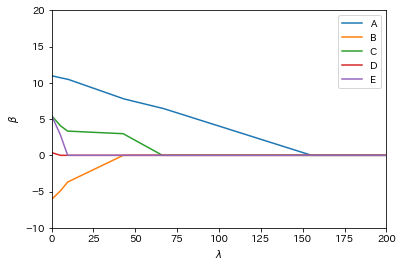

In [18]:
df = np.loadtxt("./data/input/crime.txt", delimiter="\t")
X = df[:, [i for i in range(2, 7)]]
p = X.shape[1]
y = df[:, 0]
lambda_seq = np.arange(0, 200, 0.1)
plt.xlim(0, 200)
plt.ylim(-10, 20)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\beta$")
labels = ["A", "B", "C", "D", "E"]

r = len(lambda_seq)

coef_seq = np.zeros((r, p))

for i in range(r):
    coef_seq[i, :], _ = linear_lasso(X, y, lambda_seq[i])

for j in range(p):
    plt.plot(lambda_seq, coef_seq[:, j], label=labels[j])
plt.legend(loc="upper right")